In [1]:
import enum
import seaborn as sns
from data_handling.Data_Processor import DataProcessor
import constants
import os
from statistics_methods.Statistics import StatisticsWrapper

In [36]:
raw_data_path = constants.PATH_TO_CORTEX_4_PARAMS_RAW
chosen_rois_dict = constants.ROI_CORTEX
params_to_work_with = ['r1', 'tv', 'mt', 'r2s']

In [37]:
subjects_raw_data = DataProcessor(raw_data_path, chosen_rois_dict, chosen_rois_dict).get_data_proccessed()
analyzed_data = StatisticsWrapper.calc_mean_per_subject_per_parameter_per_ROI(subjects_raw_data, params_to_work_with)
chosen_data = StatisticsWrapper.chose_relevant_data(analyzed_data, chosen_rois_dict, params_to_work_with, params_to_work_with)

In [38]:
group_a_name, group_b_name, col_divider, threshold = constants.YOUNG, constants.OLD, 'Age', constants.AGE_THRESHOLD
young_subjects, old_subjects = StatisticsWrapper.seperate_data_to_two_groups(chosen_data, col_divider, threshold)

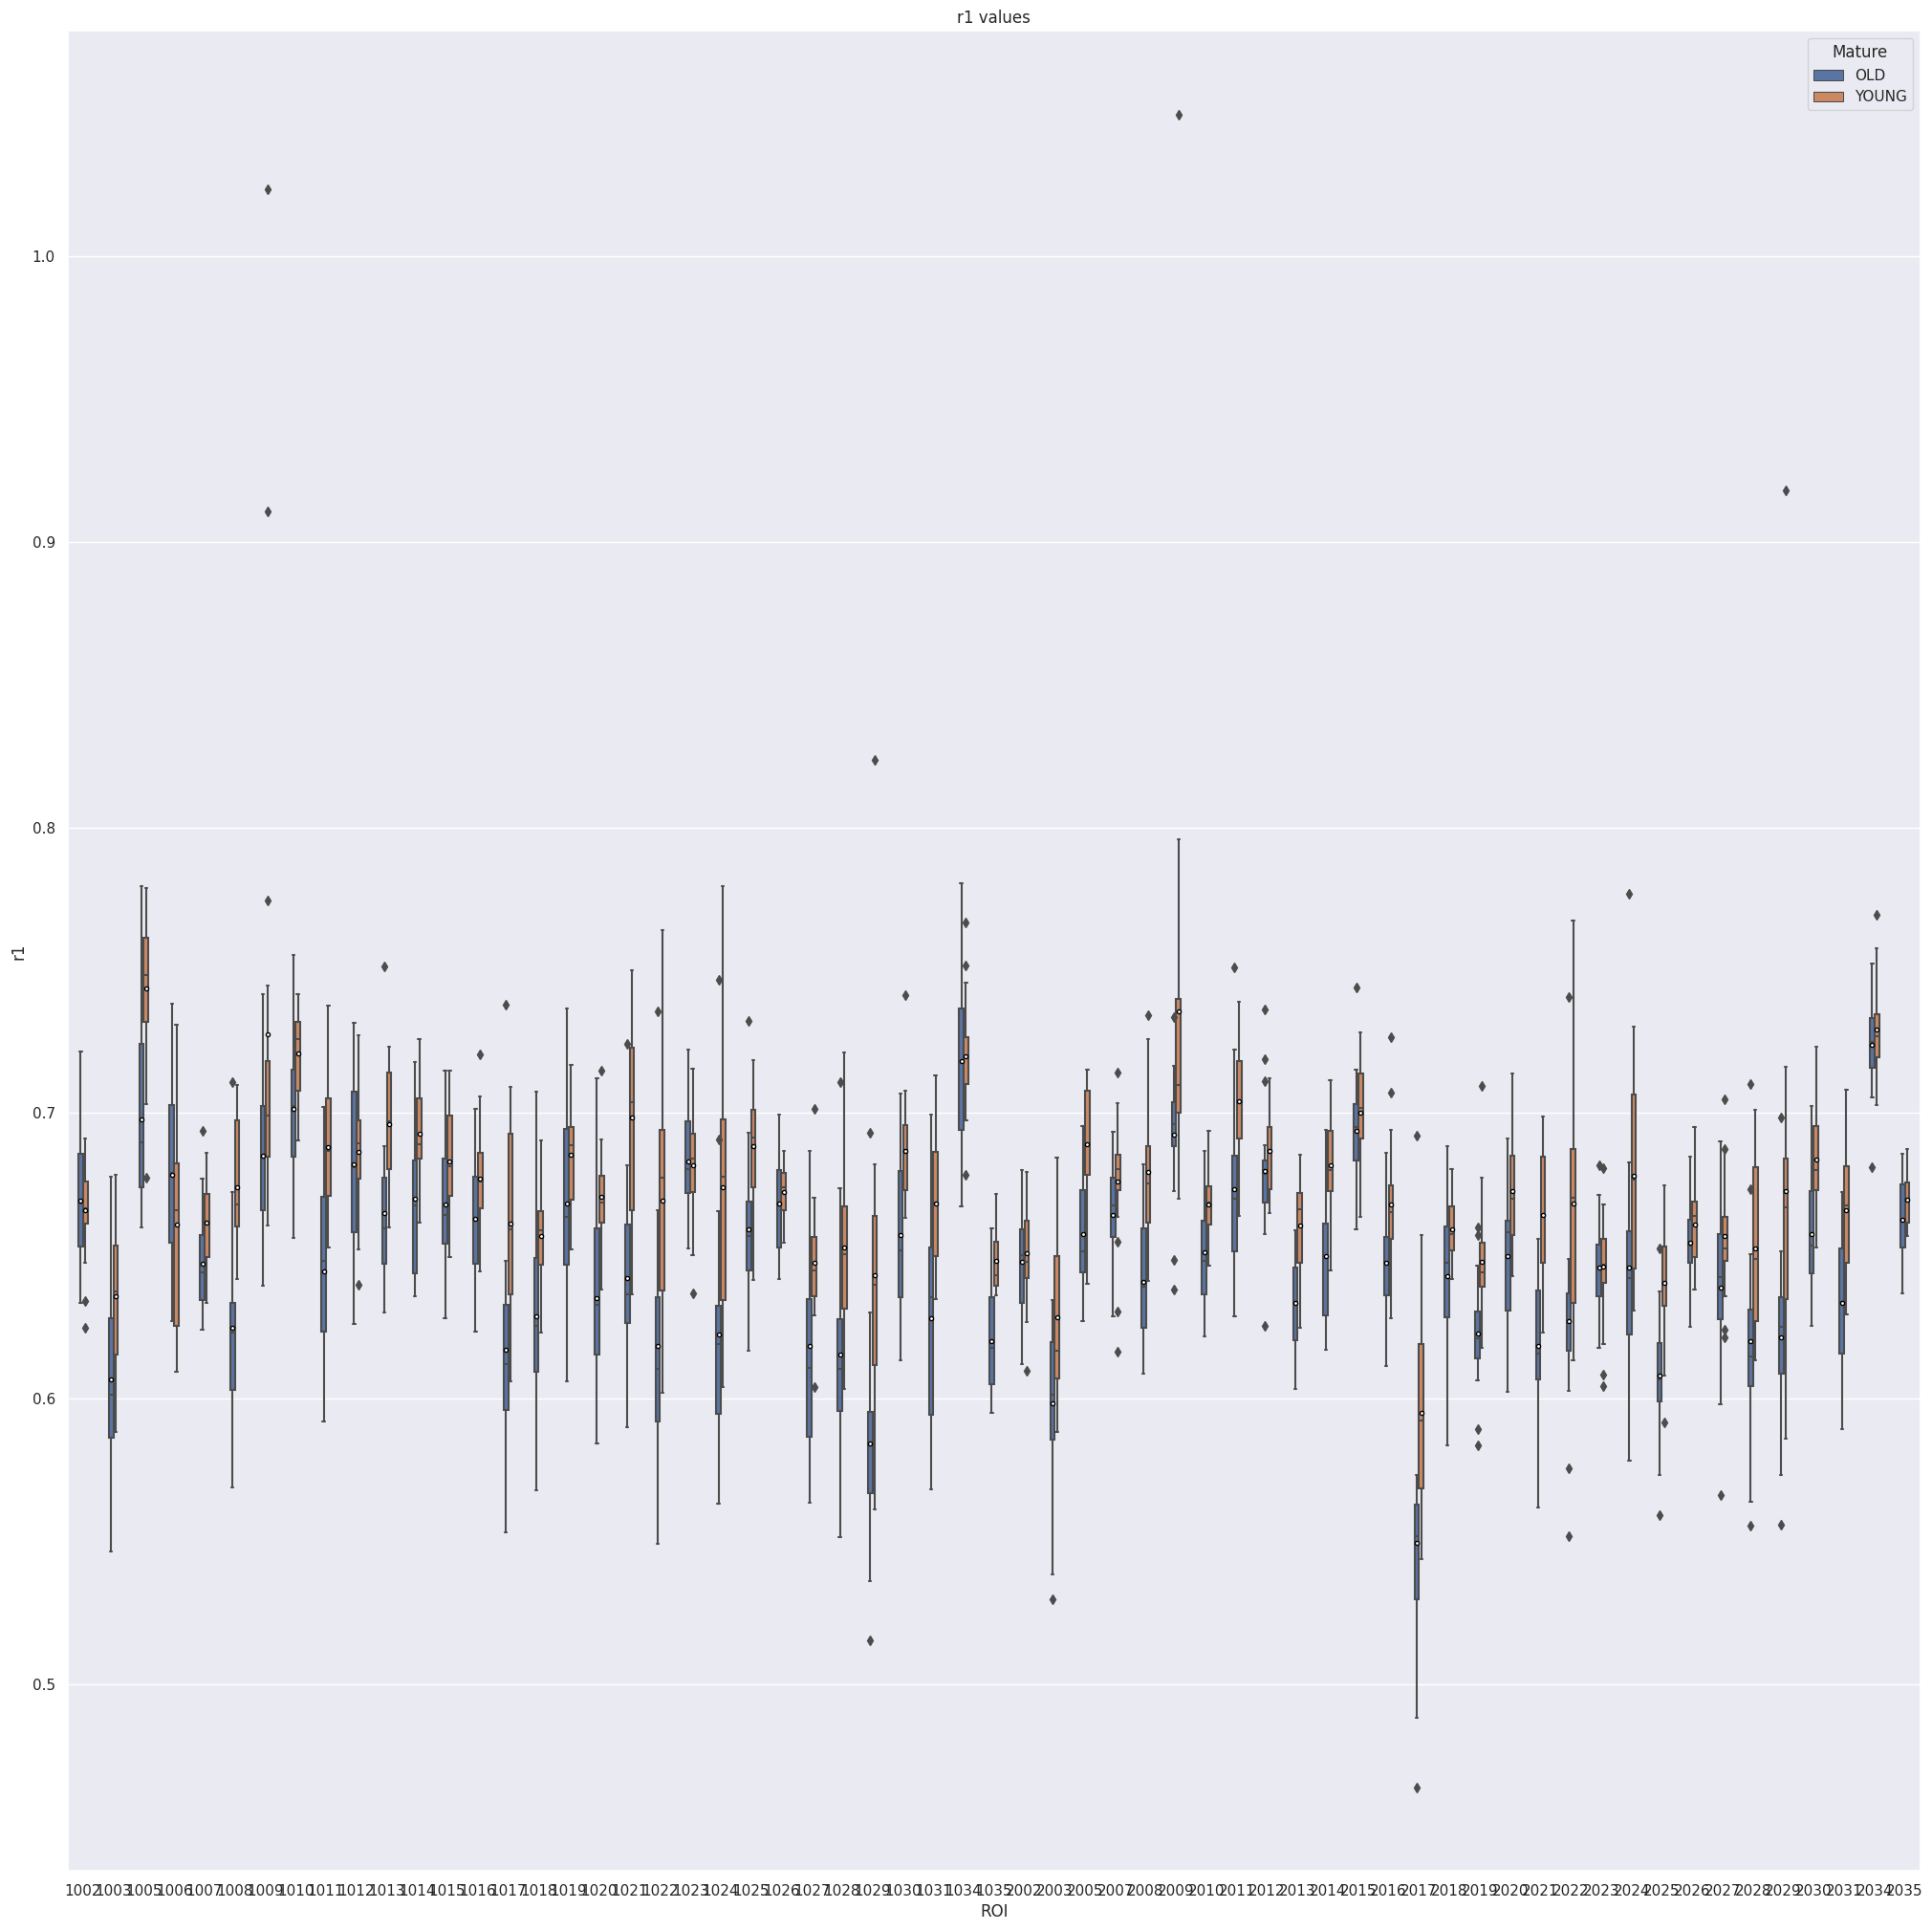

In [39]:
StatisticsWrapper.plot_data_per_param_per_roi_next_to_each_other(young_subjects, old_subjects,
                                                                    ['r1'],
                                                                    group_a_name, group_b_name)

In [102]:
low_e = 0.03
hi_e = 0.06

q_low = chosen_data["r1"].quantile(0.01) - low_e
q_hi  = chosen_data["r1"].quantile(0.99) + hi_e

chosen_data_filterd = chosen_data[(chosen_data["r1"] > q_low) & (chosen_data["r1"] < q_hi)]

subjects_values_count = chosen_data_filterd['subjects'].value_counts()
mask = chosen_data_filterd['subjects'].map(subjects_values_count) == len(chosen_rois_dict.keys())
chosen_data_filterd = chosen_data_filterd[mask]

chosen_data_filterd.subjects.nunique()

33

In [94]:
young_subjects, old_subjects = StatisticsWrapper.seperate_data_to_two_groups(chosen_data_filterd, col_divider, threshold)
print(f'young: {young_subjects.subjects.nunique()}, old: {old_subjects.subjects.nunique()}')

young: 15, old: 10


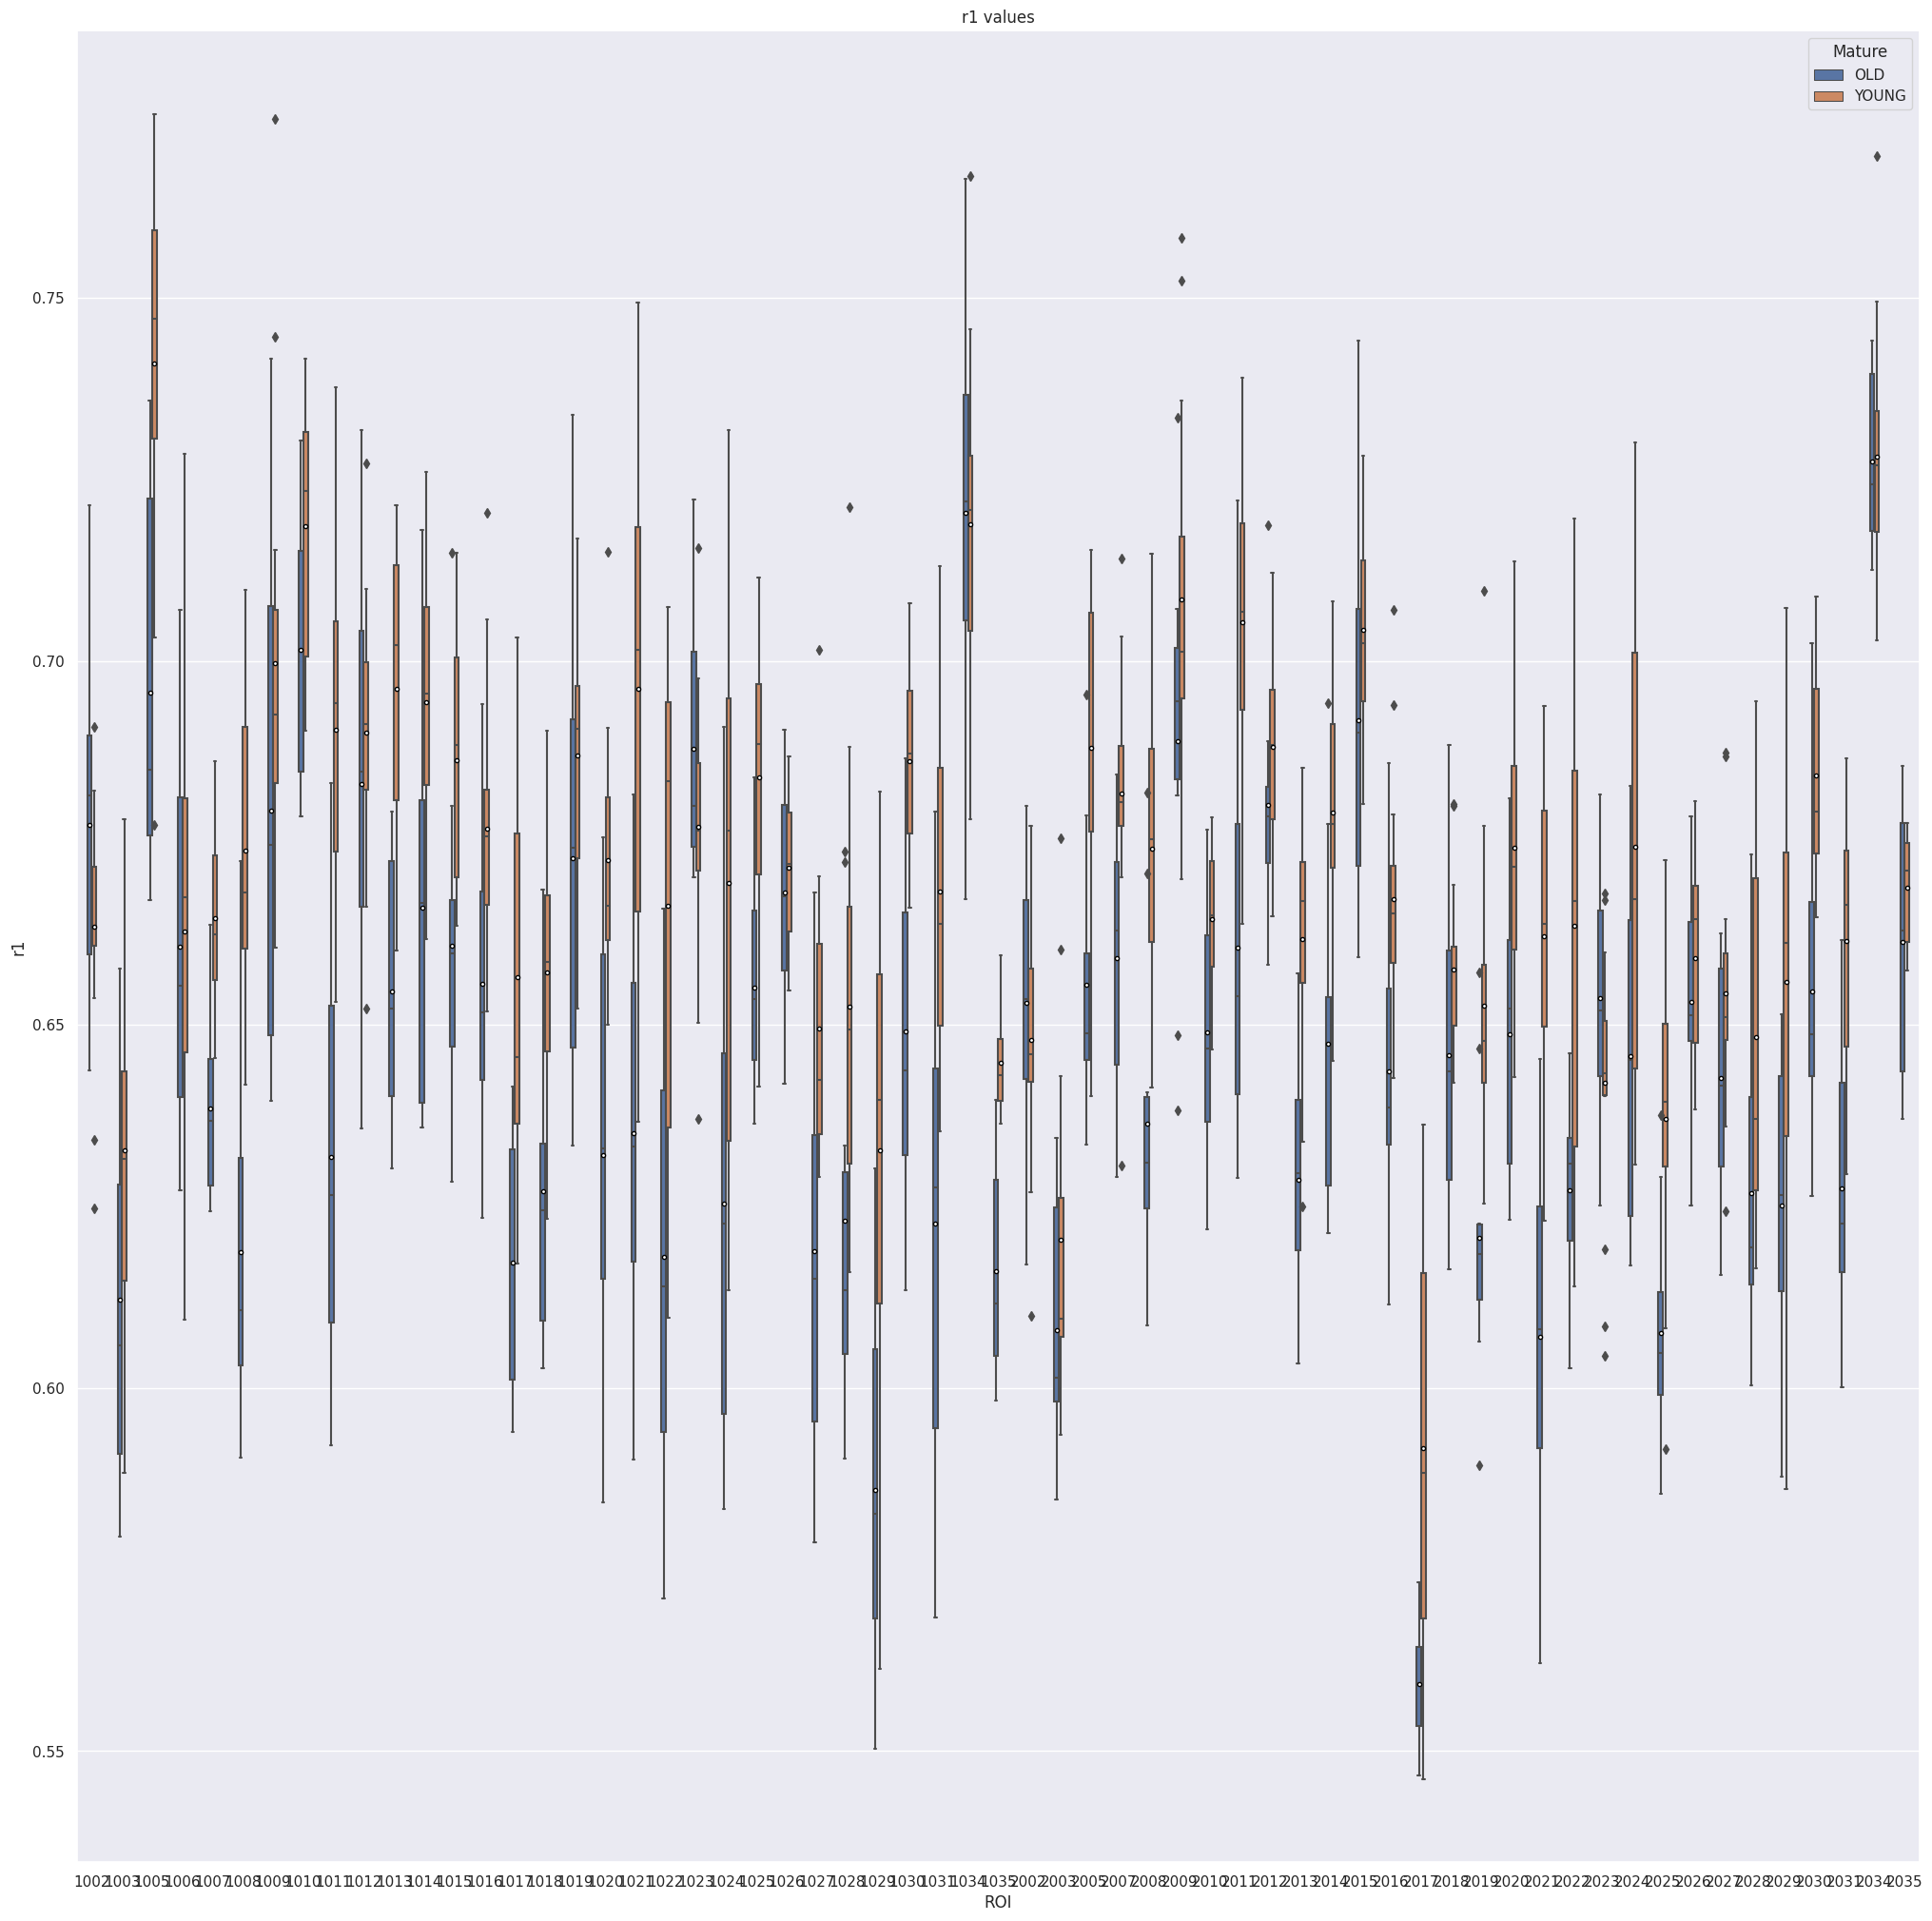

In [95]:
StatisticsWrapper.plot_data_per_param_per_roi_next_to_each_other(young_subjects, old_subjects,
                                                                    ['r1'],
                                                                    group_a_name, group_b_name)

In [105]:
removed_df = chosen_data[(chosen_data["r1"] < q_low) | (chosen_data["r1"] > q_hi)]

subjects_values_count = removed_df['subjects'].value_counts()
mask = removed_df['subjects'].map(subjects_values_count) < len(chosen_rois_dict.keys())
removed_df = removed_df[mask]

removed_df.subjects.nunique()

5

In [107]:
outliers = removed_df.subjects.unique()
outliers

array(['H023_IN', 'H034_HB', 'H050_AB', 'H054_AE', 'H056_LE'],
      dtype=object)

In [111]:
data_path = os.path.join(constants.ANALYSIS_DIR, outliers[2])
seg_path = os.path.join(data_path, os.listdir(data_path)[0], constants.BASIC_SEG)
brain_path = os.path.join(data_path, os.listdir(data_path)[0], constants.MAP_R1)

In [112]:
os.system(f'freeview -v {brain_path} {seg_path}:colormap=lut &')

0

In [130]:
import numpy as np
import pandas as pd

data = np.concatenate(subjects_raw_data['r1'].values)
data = pd.Series(data)
# data.hist(figsize=(5, 7))
data.describe()

count    1.780742e+07
mean     6.614230e-01
std      1.584608e-01
min      1.000000e-01
25%      5.920537e-01
50%      6.590350e-01
75%      7.238334e-01
max      1.000000e+01
dtype: float64